# Imports

In [41]:
from catboost import CatBoostRegressor, EFstrType, Pool, sum_models
import gc
import h5py
import json
import joblib
import mlflow
import numpy as np
import optuna
import os
import pandas as pd
import pickle
import polars as pl
import sys

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from tqdm import tqdm

In [2]:
sys.path.append('../src/')
import h5_utils

# Configs

In [4]:
settings_path = '../configs/settings.json'
with open(settings_path, 'r') as f:
    config = json.load(f)

In [5]:
folder_daily_h5 = f"../{config['RAW_DATA_DIR']}/daily/"

metadata_filename = 'metadata.h5'
metadata_filepath = f"../{config['RAW_DATA_DIR']}/{metadata_filename}"

optuna_all_feat_filename = 'optuna_all_sliding.pkl'
optuna_all_feat_filenpath = f"../{config['RAW_DATA_DIR']}/{optuna_all_feat_filename}"

In [6]:
DAY_TEST_START = 400 # train size in day terms

# Daily load trick

In [7]:
date_ids = h5_utils.load_metadata(metadata_filepath)
len(date_ids)

481

# Validation splits

In [8]:
max_train_size = 70
slide_step= max_train_size
n_samples=len(date_ids)

effective_train_size = max_train_size + gap
n_splits = (n_samples - test_size) // (effective_train_size + test_size) + 1
print(n_splits)
tscv = TimeSeriesSplit(n_splits=n_splits,
                max_train_size=max_train_size, 
                test_size=test_size, 
                gap=gap)


In [9]:
class SlidingWindowSplit:
    def __init__(self, 
                 data, 
                 train_days, 
                 #test_days, 
                 slide_step=1):
        self.data = data
        self.train_days = train_days
        self.slide_step = slide_step

    def __iter__(self):
        for i in range(self.train_days, len(self.data) + 1, self.slide_step):
            yield np.arange(i - self.train_days, i)

    def __len__(self):
        return (len(self.data) - self.train_days + 1) // self.slide_step

In [10]:
batch_ids = SlidingWindowSplit(date_ids, 
                       max_train_size, 
                       slide_step)

In [11]:
for i, train_index in enumerate(tqdm(batch_ids, 
                                    desc="Training and Validation")):
    
    print(f"Batch {i}:")
    print(f"  Train: index={train_index}")

Training and Validation: 6it [00:00, 1584.25it/s]             

Batch 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Batch 1:
  Train: index=[ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139]
Batch 2:
  Train: index=[140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209]
Batch 3:
  Train: index=[210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 23

# Preprocess

In [12]:
def drop_target_nan(features: np.ndarray,
                    target: np.ndarray)-> (np.ndarray, np.ndarray):
    
    mask = ~np.isnan(target)
    
    return features[mask], target[mask]

# Intermediate optuna on Catboost for feature selection

## Trial

In [13]:
def params_catboost(trial):
    
    param = {
        "loss_function" : "MAE",
        "eval_metric" : "MAE",
        "iterations" : 1000,  
        #"used_ram_limit": "14gb",
        #"learning_rate": trial.suggest_float("learning_rate", 
        #                              0.2, 0.9), # will optimize it later, catboost has good inner mechanism of choice
        "depth": trial.suggest_int("depth", 5, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 
                                      3, 50),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", 
                             ["Bayesian", "Bernoulli", "MVS"])
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 
                                                 1, 20)
        
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 
                                         0.1, 0.8)
    return param

In [14]:
def batch_learning(param, train_ids):
    '''All the data with such number of features can't fit in memory so we will update model by batches learning'''
    batches = SlidingWindowSplit(train_ids, 
                           max_train_size, 
                           slide_step)

    model_prev = None

    for batch_ind in tqdm(batches, desc="Batch training:"):
        batch_train_days = date_ids[batch_ind]
        
        # Load training data
        train_data, train_labels = h5_utils.stacked_daily_data(batch_train_days,
                                                              folder_daily_h5)

        # Preprocess
        ## Target handle NaNs
        train_data, train_labels = drop_target_nan(train_data, 
                                                   train_labels)

        batch = Pool(train_data, 
                     label=train_labels)

        model_new = CatBoostRegressor(**param, thread_count=-1, random_seed=42)
        if model_prev is None:
            model_new.fit(X=batch, verbose=1)
            model_prev = model_new
        else:
            # https://catboost.ai/en/docs/concepts/python-usages-examples#batch-training
            batch.set_baseline(model_prev.predict(batch))
            model_new.fit(X=batch, verbose=0)
            model_prev = sum_models([model_prev,model_new])
        
    return model_prev

In [15]:
def objective(trial):
    # CV
    train_ids = date_ids[:DAY_TEST_START]
    test_ids = date_ids[DAY_TEST_START:]
    
    param = params_catboost(trial)
    # Train
    final_model = batch_learning(param, train_ids)

    # Score
    ## Load validation data
    valid_data, valid_labels = h5_utils.stacked_daily_data(test_ids,
                                                          folder_daily_h5)
    ## NaN in target is not scored by the rules
    valid_data, valid_labels = drop_target_nan(valid_data, 
                                               valid_labels)
    valid_preds = final_model.predict(valid_data)
    ## Calculate metric
    mae = mean_absolute_error(valid_labels, valid_preds)
    return mae

## Search

In [ ]:
%%time

hours = 10

study = optuna.create_study(direction='minimize',
                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, 
               n_trials=120,
               timeout = 60*60*hours
              )
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [20]:
print("Best trial: score {}, params {}".format(study.best_trial.value, 
					       study.best_trial.params))

Best trial: score 0.6507658887344581, params {'depth': 5, 'l2_leaf_reg': 18, 'bootstrap_type': 'MVS'}


In [21]:
len(study.trials)

2

## Store study (optional)

In [20]:
joblib.dump(study, optuna_all_feat_filenpath)

['.././data//optuna_all_sliding.pkl']

## Observe hyper importances

optuna.visualization.plot_param_importances(study)

In [ ]:
import matplotlib.pyplot as plt

# Get parameter importances
param_importances = optuna.importance.get_param_importances(study)

# Prepare data for visualization
names = list(param_importances.keys())
values = list(param_importances.values())

# Create bar plot
plt.figure(figsize=(10, 5))
plt.barh(names, values, color='blue')
plt.xlabel('Importance')
plt.title('Parameter Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.show()

# Selection

300 features
1) exprimentaly can be fited on kaggle as one batch
2) can satify time limit to be retrained multiple times during test inference

## Best model fit

In [27]:
gc.collect()

1621

In [ ]:
%%time
data_train = date_ids[:DAY_TEST_START]
best_model = batch_learning(study.best_trial.params,
                            data_train)

## Store best on all features (optional)

In [34]:
best_model.save_model('Batched_all_feats_444',
           format="cbm",
           export_parameters=None,
           pool=None)

## Catboost importance approach

In [29]:
feature_importance_catboost2 = best_model.get_feature_importance(type=EFstrType.FeatureImportance, 
				   prettified=True, 
				   thread_count=-1, 
				   verbose=True)

In [30]:
feature_importance_catboost2

,Feature Id,Importances
0,417,54.606904
1,422,10.900339
2,442,5.255750
3,440,5.199438
4,393,4.570083
...,...,...
438,206,0.000007
439,108,0.000000
440,111,0.000000
441,114,0.000000


## Feature names from h5

In [31]:
date_id=date_ids[-1]
filepath=f'{folder_daily_h5}/{date_id}.h5'
with h5py.File(filepath, 'r') as f:
    # Load the target column
    target = f['data']['target'][:]

    features_group = f['data']['features']
    feature_names = list(features_group.keys())

In [32]:
feature_names[:5]

['ask_auc_money',
 'ask_money',
 'ask_price',
 'ask_price_diff_1',
 'ask_price_diff_10']

## Bar plot of top n

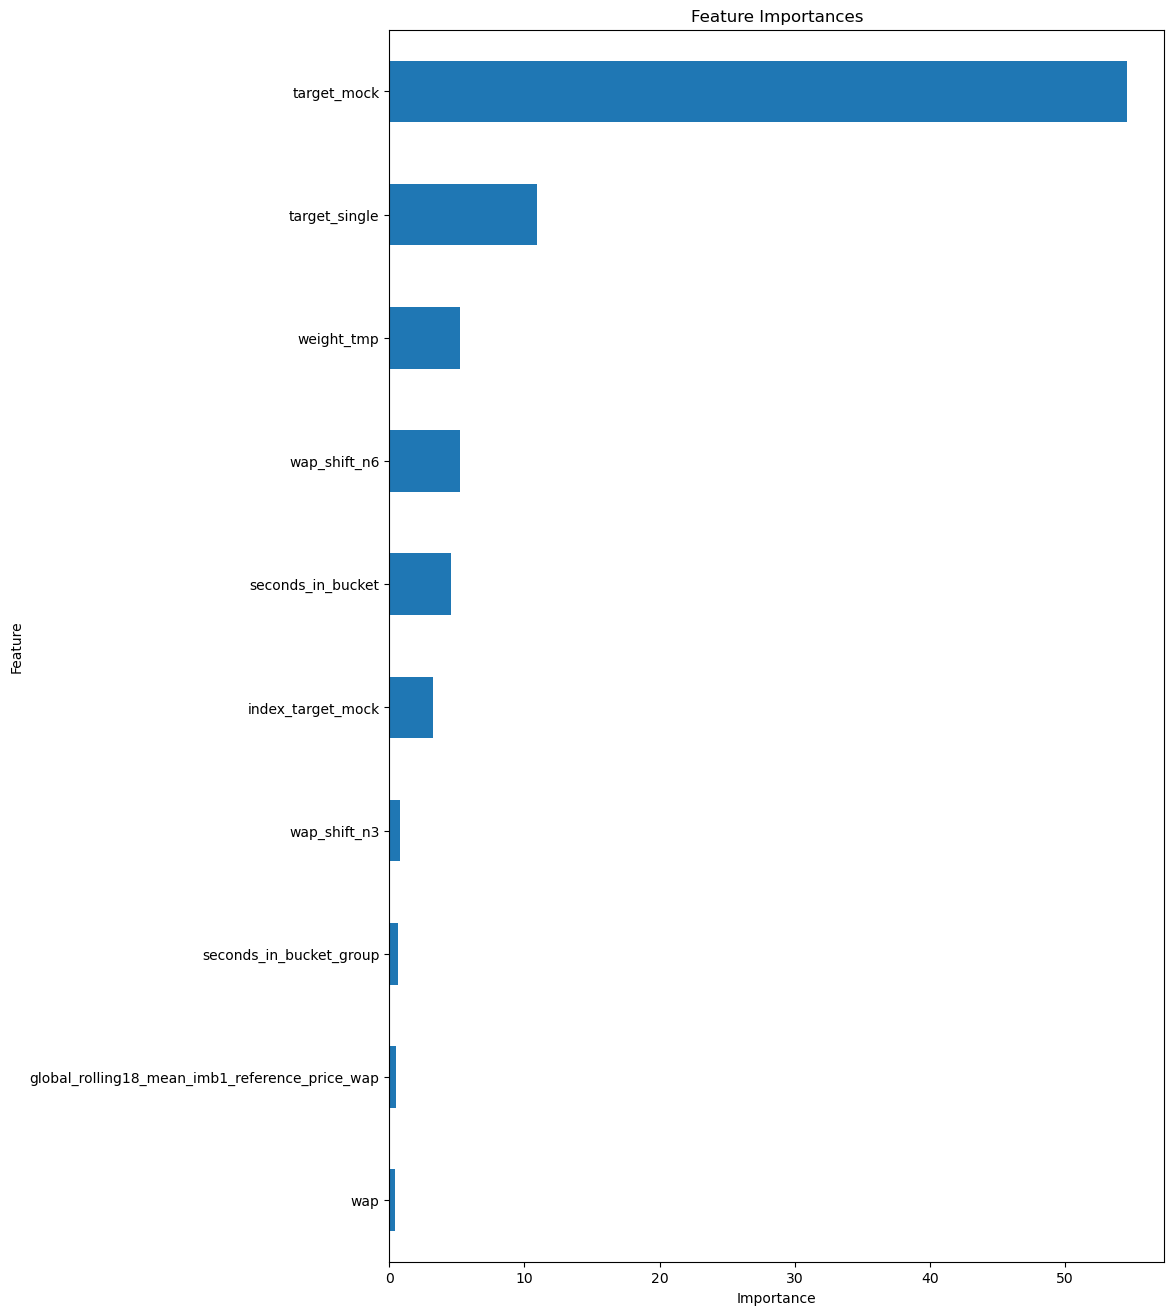

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

feature_id_to_name = {str(id): name for id, name in enumerate(feature_names)}

feature_importance_catboost2['Feature'] = feature_importance_catboost2['Feature Id'].map(feature_id_to_name)

top_n = 10
top_features = feature_importance_catboost2.head(top_n)

ax = top_features.plot(kind='barh', 
                       x='Feature', 
                       y='Importances', 
                       figsize=(10, 16), 
                       legend=False)

plt.gca().invert_yaxis()

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Seconds in bucket group is one of the top 10 features

In [37]:
top_features = feature_importance_catboost2.head(300)
top_feature_names = top_features['Feature'].tolist()

top_feature_names[:5]

['target_mock',
 'target_single',
 'weight_tmp',
 'wap_shift_n6',
 'seconds_in_bucket']

In [43]:
len(top_feature_names)

300

In [42]:
with open(f"../{config['RAW_DATA_DIR']}/top_300_feats_nms.pkl", 'wb') as f:
    pickle.dump(top_feature_names, f)